In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_fMullerBrown.recursive_LSTM_PostMeanScore_MullerBrown_T256_H05_tl_110data import \
    get_config

In [2]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


1.4260577409046697 0.023309846602439288 inf


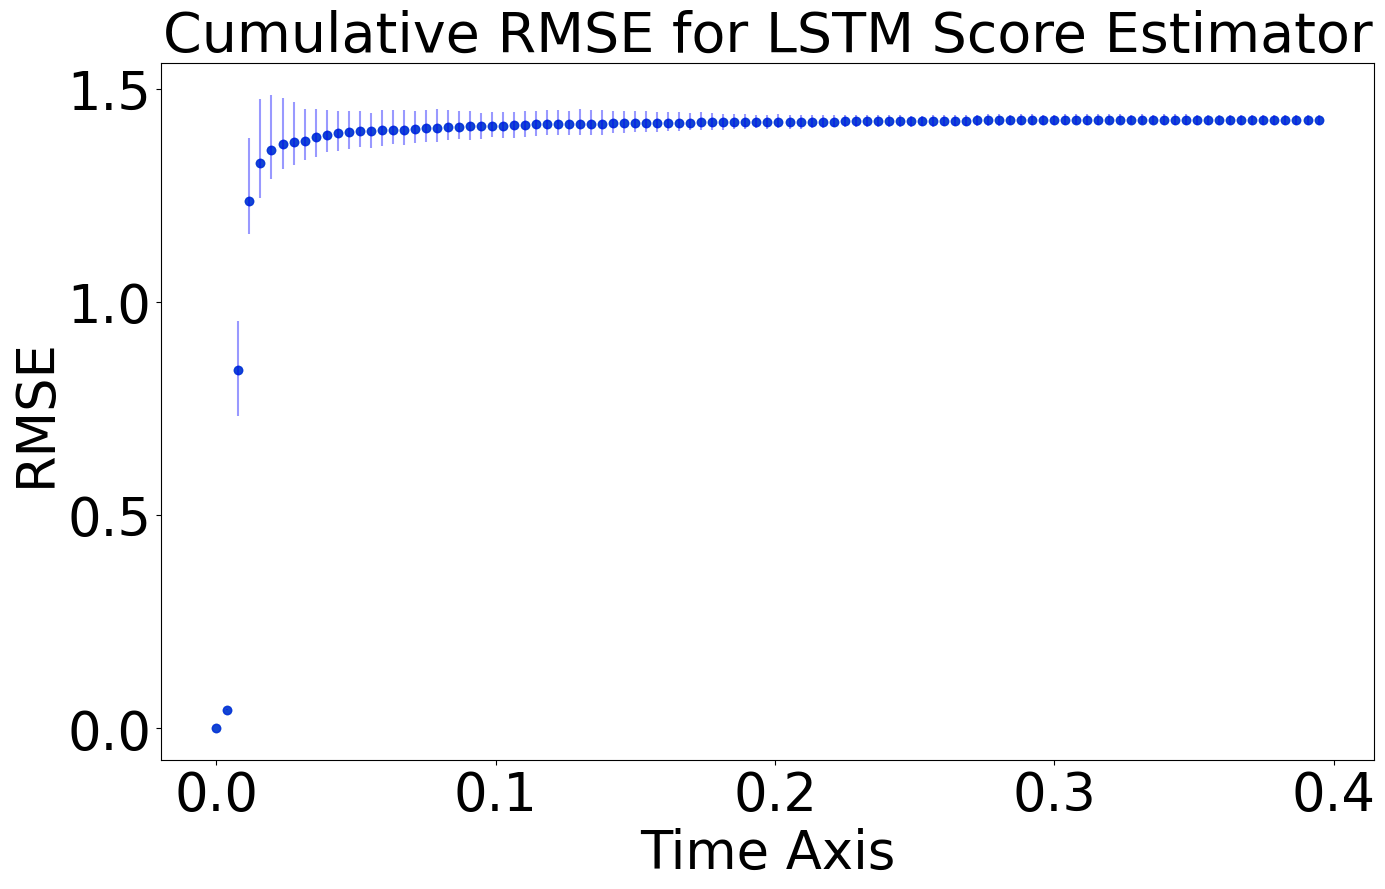

Final time cumulative RMSE local-time error 1.4260577409046697 with final IQR (1.4148987385193552, 1.4382085851217945) at Nepoch 60

1.4121937444200061 0.0198104233333114 1.4260577409046697


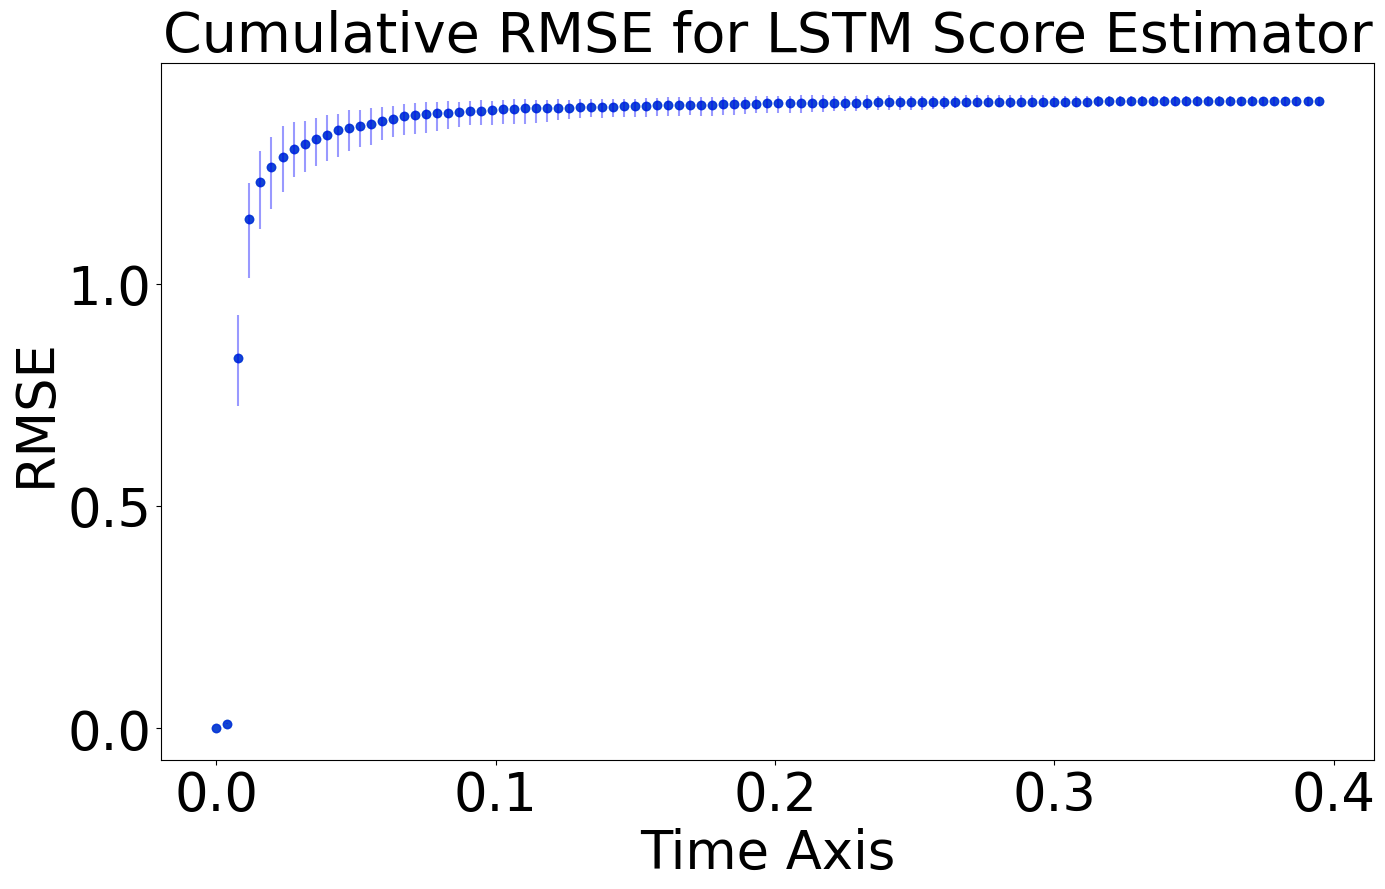

Final time cumulative RMSE local-time error 1.4121937444200061 with final IQR (1.40121899471489, 1.4210294180482015) at Nepoch 100

1.408528215012428 0.018739404502421175 1.4121937444200061


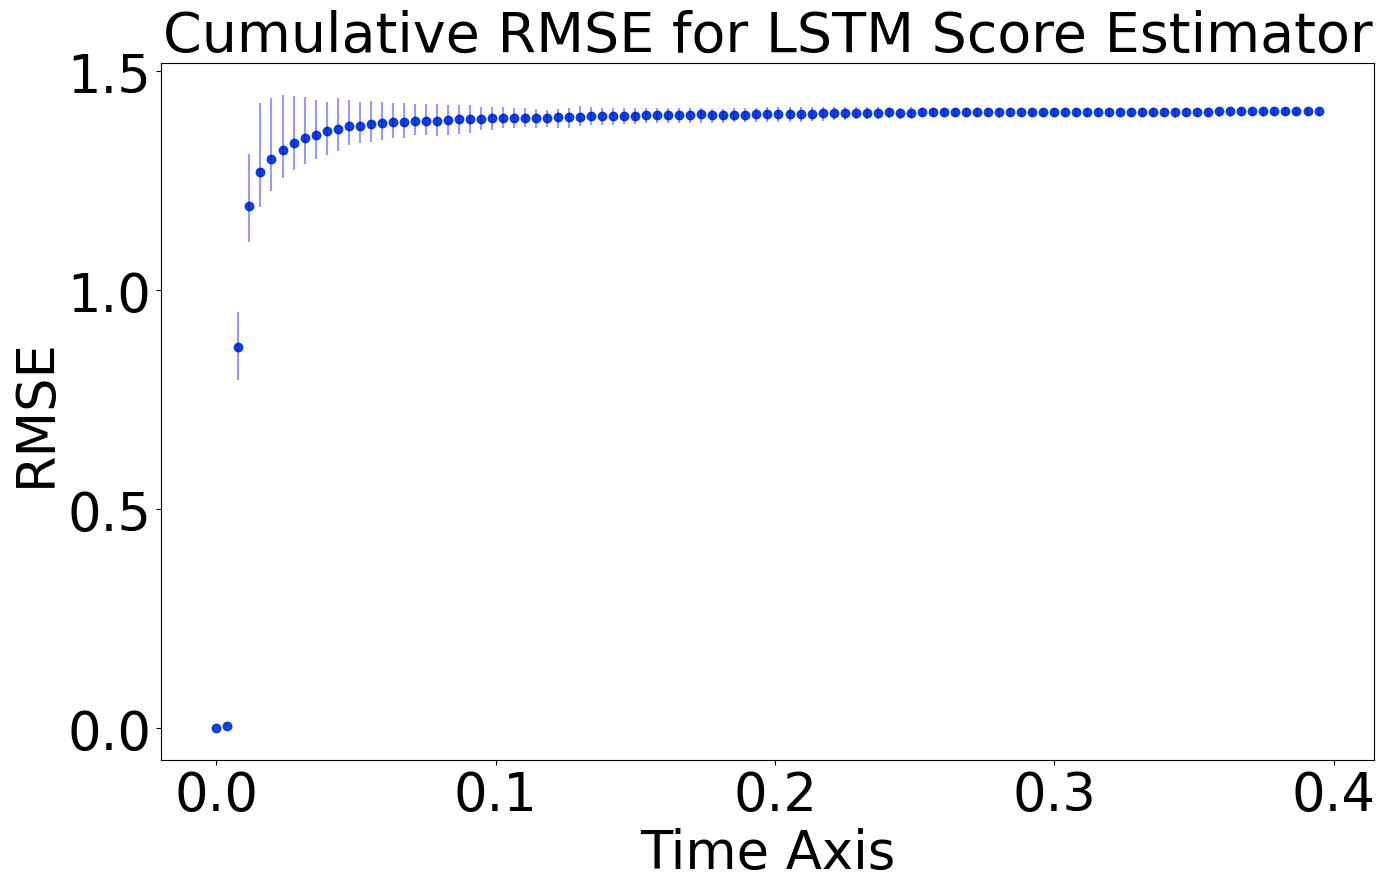

Final time cumulative RMSE local-time error 1.408528215012428 with final IQR (1.397388794462577, 1.416128198964998) at Nepoch 150

1.3872864772348228 0.029325866807227596 1.408528215012428


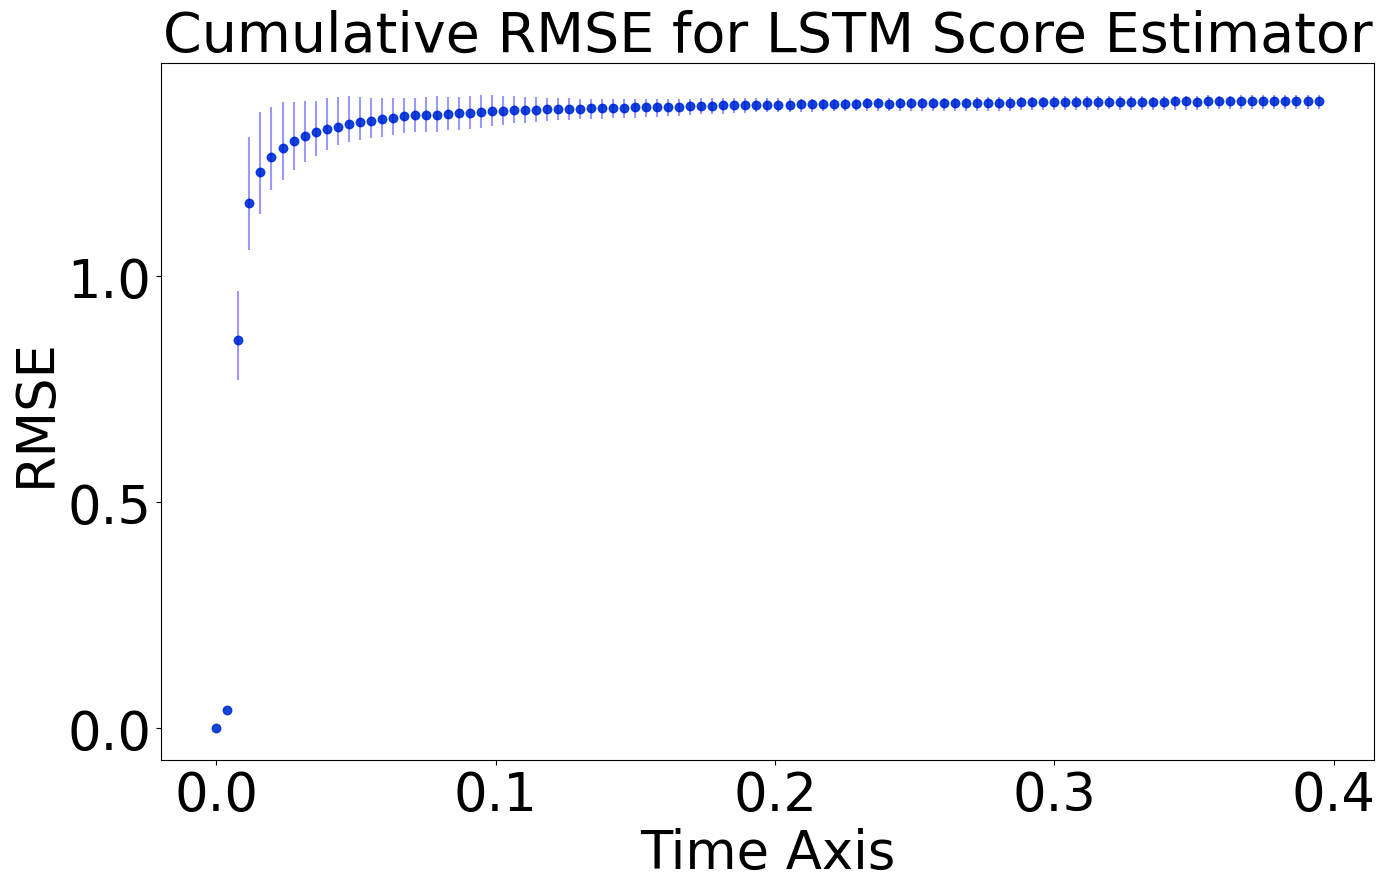

Final time cumulative RMSE local-time error 1.3872864772348228 with final IQR (1.3705098165523126, 1.3998356833595402) at Nepoch 300

1.1418003848858354 0.022928752404406616 1.3872864772348228


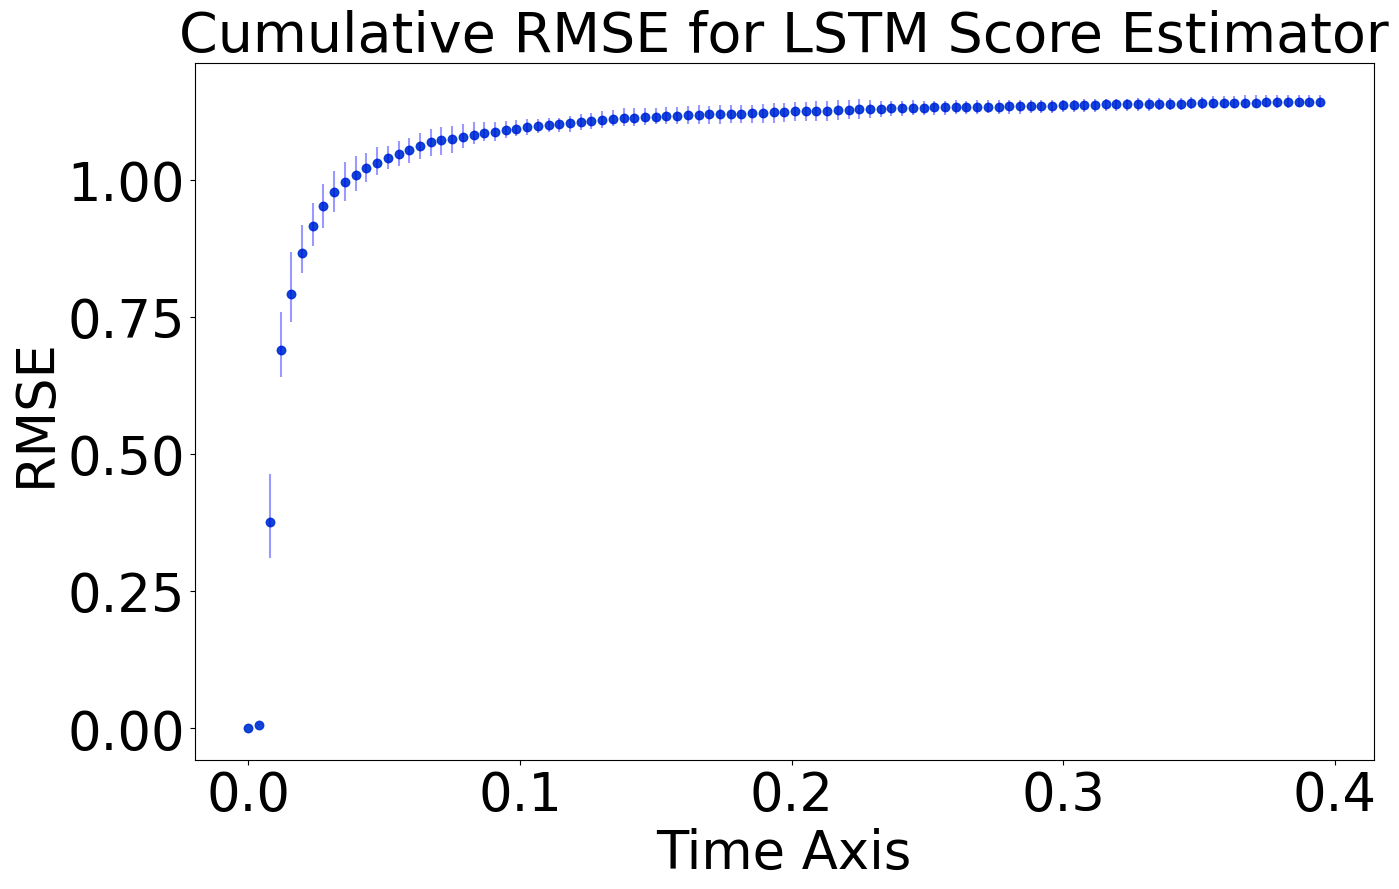

Final time cumulative RMSE local-time error 1.1418003848858354 with final IQR (1.1321966132153827, 1.1551253656197893) at Nepoch 960

1.1667843317519642 0.032272608608885145 1.1418003848858354
1.1434784972350942 0.039181607763784765 1.1418003848858354
1.1749715304585737 0.028316361420738678 1.1418003848858354
1.1982270143559195 0.02113983139926079 1.1418003848858354
1.1954270116395214 0.026140257765108865 1.1418003848858354
1.2197861475625356 0.037930365485672635 1.1418003848858354
1.4991493409469905 0.08209023454132147 1.1418003848858354


In [3]:
curr_rmse = np.inf
toSave = True
for Nepoch in config.max_epochs:
    try:
        num_diff_times = 1
        save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fMullerBrown_OOSDriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
            ".", "")
        all_true_states = np.load(save_path + "_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse)
        if total_local_errors[-1]  < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fMullerBrown_OOSDriftTrack_{Nepoch}Nep_PM_LSTM").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with final IQR {total_local_errors_minq[-1],total_local_errors_maxq[-1]} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        continue